#

Eq. (8.141), with $q_i=1$:

$$
    \dfrac{P}{P_0} = 1 + \dfrac{6\pi\epsilon_0}{\lvert\mathbf{p}\rvert^2} \dfrac{1}{k^3} \operatorname{Im}\left\{ \mathbf{p}^{\ast} \cdot \mathbf{E}_{ref} (\mathbf{r}_0) \right\}
$$

Eq. (10.25):

$$
 \overleftrightarrow{\mathbf{G}}_{ref}(\mathbf{r}_0, \mathbf{r}_0) = \dfrac{i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} \left[\begin{matrix} k_1^2 r^s - k_{z_1}^2 r^p & 0 & 0\\ 0 & k_1^2 r^s - k_{z_1}^2 r^p & 0\\ 0 & 0 & 2k_{\rho}^2 r^p\end{matrix} \right] e^{2ik_{z_1}z_0} dk_{\rho}
$$

From (10.23):

$$
    \mathbf{E}_{ref} (\mathbf{r}_0) = \omega^2\mu_0\mu_1 \overleftrightarrow{\mathbf{G}}_{ref}(\mathbf{r}_0, \mathbf{r}_0) \cdot \mathbf{p}
$$

Therefore, inserting (10.23) into (8.141) means to solve the product (assuming $\mu_1 \simeq 1$):

$$
    \mathbf{p}^{\ast} \cdot \mathbf{E}_{ref} (\mathbf{r}_0) = \mathbf{p}^{\ast} \cdot \omega^2\mu_0 \overleftrightarrow{\mathbf{G}}_{ref}(\mathbf{r}_0, \mathbf{r}_0) \mathbf{p} =
$$

and finally inserting the (very long) eq. (10.25):

$$
    = \dfrac{\omega^2\mu_0 i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} \mathbf{p}^{\ast} \cdot \overleftrightarrow{\mathbf{M}} \cdot \mathbf{p} ~ e^{2ik_{z_1}z_0} dk_{\rho}
$$

where $\overleftrightarrow{\mathbf{M}}$ is the inner matrix.

We end up solving the following matrix product:

$$
    \mathbf{p}^{\ast} \cdot \overleftrightarrow{\mathbf{M}} \cdot \mathbf{p} = \left[\begin{matrix} p_x & p_y & p_z\end{matrix} \right] \left[\begin{matrix} M_1 & 0 & 0\\ 0 & M_1 & 0\\ 0 & 0 & M_2\end{matrix} \right] \left[\begin{matrix} p_x \\ p_y \\ p_z\end{matrix} \right]
$$

In the end we get:

$$
    = \dfrac{\omega^2\mu_0 i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} (p_x^2 + p_y^2) (k_1^2 r^s - k_{z_1}^2 r^p) ~ e^{2ik_{z_1}z_0} dk_{\rho} + \dfrac{\omega^2\mu_0 i}{8\pi k_1^2} \int_0^{\infty} \dfrac{k_{\rho}}{k_{z_1}} p_z^2 2k_{\rho}^2 r^p ~ e^{2ik_{z_1}z_0} dk_{\rho}
$$

We can try to make our life easier (not so sure how much tho...) with the following substitutions:

$$ s = k_{\rho} / k_{1} \qquad \qquad \qquad \qquad \qquad \rightarrow \qquad ds = 1/k_1 dk_{\rho} $$

$$ s_z = s_z(s) = \sqrt{1-s^2} = k_{z_{1}}/k_{1} $$

so to have:

$$
    = \dfrac{\omega^2\mu_0 i}{8\pi} (p_x^2 + p_y^2) \int_0^{\infty} \dfrac{s}{k_{z_1}/k_1^2} (r^s - s_z^2 r^p) ~ e^{2ik_1z_0s_z} ds + \dfrac{\omega^2\mu_0 i}{8\pi} 2p_z^2 \int_0^{\infty}  k_1 \dfrac{s^3}{s_z} r^p ~ e^{2ik_1z_0s_z} ds
$$

Final effort! Plug what we just obtained in (8.141) and [play](https://open.spotify.com/track/7iAqvWLgZzXvH38lA06QZg):

$$
    \dfrac{P}{P_0} = 1 + \dfrac{6\pi\epsilon_0}{\lvert\mathbf{p}\rvert^2} \dfrac{1}{k_1^3} \operatorname{Im}\left\{ \dfrac{\omega^2\mu_0 i}{8\pi} (p_x^2 + p_y^2) \int_0^{\infty} \dfrac{s}{k_{z_1}/k_1^2} (r^s - s_z^2 r^p) ~ e^{2ik_1z_0s_z} ds \right\}
$$

$$
     + \dfrac{6\pi\epsilon_0}{\lvert\mathbf{p}\rvert^2} \dfrac{1}{k_1^3} \operatorname{Im}\left\{ \dfrac{\omega^2\mu_0 i}{8\pi} 2p_z^2 \int_0^{\infty}  k_1 \dfrac{s^3}{s_z} r^p ~ e^{2ik_1z_0s_z} ds \right\} =
$$

$$
    = 1 + \dfrac{(p_x^2 + p_y^2)}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{4}  \dfrac{\epsilon_0\mu_0\omega^2}{k^2}\operatorname{Im}\left\{ i \int_0^{\infty} \dfrac{s}{s_{z}} (r^s - s_z^2 r^p) ~ e^{2ik_1z_0s_z} ds \right\} + \dfrac{p_z^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{2} \dfrac{\epsilon_0\mu_0\omega^2}{k^2}  \operatorname{Im}\left\{ i \int_0^{\infty} \dfrac{s^3}{s_z} r^p ~ e^{2ik_1z_0s_z} ds \right\}
$$

And finally considering that:

$$ \epsilon_0\mu_0\omega^2 = k^2 $$

and that holds the relation:

$$ \operatorname{Im}\left\{ i \cdot n \right\} \qquad\qquad\rightarrow \qquad\qquad \operatorname{Re}\left\{ n \right\} $$

we finally get (10.26):

$$\dfrac{P}{P_0}(z_0) = 1 + \dfrac{p_x^2 + p_y^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{4} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s}{s_z} \left[r^s - s_z^2 r^p\right] e^{2 i k_1 z_0 s_z} \right\}ds + \dfrac{p_z^2}{\lvert\mathbf{p}\rvert^2} \dfrac{3}{2} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s^3}{s_z} r^p e^{2ik_1z_0s_z} \right\}ds $$

Reminder:

$$ k_{z_1} = \sqrt{k_1^2 - (k_x^2 + k_y^2)}  \newline k_{z_2} = \sqrt{k_2^2 - k_{\rho}^2}, \qquad\qquad\qquad\qquad\text{w.      }\quad k_{\rho}^2 = k_{x_2}^2 + k_{y_2}^2 $$

Given the following geometry:
<div>
<img src="assets/geometry.png" width="500"/>
</div>

The dipole can be written as:

$$ p_x = \lvert\mathbf{p}\rvert \sin(\theta) \cos(\phi) \newline $$
$$ p_y = \lvert\mathbf{p}\rvert \sin(\theta) \sin(\phi) \newline $$
$$ p_z = \lvert\mathbf{p}\rvert \cos(\theta) \newline $$

so to simplify the main equation to:

$$\dfrac{P}{P_0}(z_0) = 1 + \sin^2(\theta) \dfrac{3}{4} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s}{s_z} \left[r^s - s_z^2 r^p\right] e^{2 i k_1 z_0 s_z} \right\}ds + \cos^2(\theta) \dfrac{3}{2} \int_0^{\infty} \operatorname{Re}\left\{\dfrac{s^3}{s_z} r^p e^{2ik_1z_0s_z} \right\}ds $$

For the integration we have:

$$\dfrac{P}{P_0}_{tot}(z_0) = 1 + f(\theta) \int_0^{1} I(s) ds + g(\theta) \int_0^{1} J(s) ds + f(\theta) \int_1^{\infty} I(s) ds + g(\theta) \int_1^{\infty} J(s) ds = \dfrac{P}{P_0}_{rad} + \dfrac{P}{P_0}_{non~rad}$$

**Fresnel Coefficients**

$$ r^s = \dfrac{k_{z_1} - k_{z_2}}{k_{z_1} + k_{z_2}} \\[10pt] r^p = \dfrac{\epsilon_2 k_{z_1} - \epsilon_1 k_{z_2}}{\epsilon_2 k_{z_1} + \epsilon_1 k_{z_2}} $$

#

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [45]:
# Constants
eps1=1
eps2=2.25 

h=np.linspace(0.001,2,1000) #.'; % normalized height z0/lambda

wl = 488e-9  # in m
k0=2*np.pi/wl

k1=np.sqrt(eps1)*k0
k2=np.sqrt(eps2)*k0

theta=90*np.pi/180

def IntegrandDecayRatesXY(s,h,eps2):
    eps1=1

    wl = 488e-9  # in m
    k0=2*np.pi/wl

    k1=np.sqrt(eps1)*k0
    k2=np.sqrt(eps2)*k0

    sz=np.sqrt(1-s**2 + 0j)

    
    krho=s*k1
    kz1=sz*k1

    kz2=np.sqrt(k2**2-krho**2 + 0j)

    r_s=(kz1-kz2)/(kz1+kz2)

    r_p=(eps2*kz1-eps1*kz2)/(eps2*kz1+eps1*kz2)

    return np.real(s/sz*(r_s-sz**2*r_p)*np.exp(4*np.pi*1j*h*sz))

def IntegrandDecayRatesZ(s,h,eps2):
    eps1=1

    wl = 488e-9  # in m
    k0=2*np.pi/wl

    k1=np.sqrt(eps1)*k0
    k2=np.sqrt(eps2)*k0

    sz=np.sqrt(1-s**2 + 0j)

    krho=s*k1
    kz1=sz*k1
    kz2=np.sqrt(k2**2-krho**2 + 0j)

    r_p=(eps2*kz1-eps1*kz2)/(eps2*kz1+eps1*kz2)

    return np.real(s**3/sz*r_p*np.exp(4*np.pi*1j*h*sz))

gammaRadD_rel=np.zeros((len(h),1))
gammaNRD_rel=np.zeros((len(h),1))
for i in range(len(h)):
    n=100
    Smax = np.sqrt(n**2/((4*np.pi*h[i])**2)+1)
    IntS = np.linspace(1.0001,Smax,500)
    
    gammaRadD_rel[i] = 1 + \
        np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY, 0, 0.9999, args=(h[i],eps2))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ, 0, 0.9999, args=(h[i],eps2))[0]
    gammaNRD_rel[i] = np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY,1.000,np.inf, args=(h[i],eps2))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ,1.000,np.inf, args=(h[i],eps2))[0]

gammaD_rel=gammaRadD_rel+gammaNRD_rel

e2m = -34.5+8.5*1j
gammaRadM_rel=np.zeros((len(h),1))
gammaNRM_rel=np.zeros((len(h),1))
for i in range(len(h)):
    n=100
    Smax = np.sqrt(n**2/((4*np.pi*h[i])**2)+1)
    IntS = np.linspace(1.0001,Smax,500)
    
    gammaRadM_rel[i] = 1 + \
        np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY, 0, 0.9999, args=(h[i],e2m))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ, 0, 0.9999, args=(h[i],e2m))[0]
    gammaNRM_rel[i] = np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY,1.000,np.inf, args=(h[i],e2m))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ,1.000,np.inf, args=(h[i],e2m))[0]

gammaM_rel=gammaRadM_rel+gammaNRM_rel

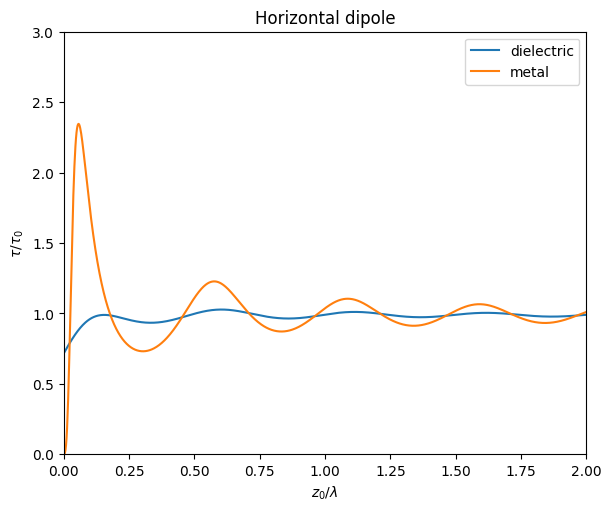

In [49]:
# plot
fig, ax = plt.subplots(figsize=(6,5), layout='constrained') # (width, height) in inches
ax.set_title("Horizontal dipole")
# ax.plot(h,gammaRad_rel, label=r"$\tau/\tau_0 (rad)$")
# ax.plot(h,gammaNR_rel, label=r"$\tau/\tau_0 (non rad)$")
ax.plot(h,1/gammaD_rel, label=r"dielectric")
ax.plot(h,1/gammaM_rel, label=r"metal")
# ax.plot(norm_height,1/(gamma_radm+gamma_nonradm), label=r"metal")
ax.set_ylim(0,3)
ax.set_ylabel(r"$\tau/\tau_0$")
ax.set_xlabel(r"$z_0/\lambda$")
l = ax.legend(loc='upper right', fancybox=True)
ax.set_xlim([0, 2])
plt.show()

In [50]:
theta=0
gammaRadD_rel=np.zeros((len(h),1))
gammaNRD_rel=np.zeros((len(h),1))
for i in range(len(h)):
    n=100
    Smax = np.sqrt(n**2/((4*np.pi*h[i])**2)+1)
    IntS = np.linspace(1.0001,Smax,500)
    
    gammaRadD_rel[i] = 1 + \
        np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY, 0, 0.9999, args=(h[i],eps2))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ, 0, 0.9999, args=(h[i],eps2))[0]
    gammaNRD_rel[i] = np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY,1.000,np.inf, args=(h[i],eps2))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ,1.000,np.inf, args=(h[i],eps2))[0]

gammaD_rel=gammaRadD_rel+gammaNRD_rel

e2m = -34.5+8.5*1j
gammaRadM_rel=np.zeros((len(h),1))
gammaNRM_rel=np.zeros((len(h),1))
for i in range(len(h)):
    n=100
    Smax = np.sqrt(n**2/((4*np.pi*h[i])**2)+1)
    IntS = np.linspace(1.0001,Smax,500)
    
    gammaRadM_rel[i] = 1 + \
        np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY, 0, 0.9999, args=(h[i],e2m))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ, 0, 0.9999, args=(h[i],e2m))[0]
    gammaNRM_rel[i] = np.sin(theta)**2*3/4*integrate.quad(IntegrandDecayRatesXY,1.000,np.inf, args=(h[i],e2m))[0] + \
        np.cos(theta)**2*3/2*integrate.quad(IntegrandDecayRatesZ,1.000,np.inf, args=(h[i],e2m))[0]

gammaM_rel=gammaRadM_rel+gammaNRM_rel

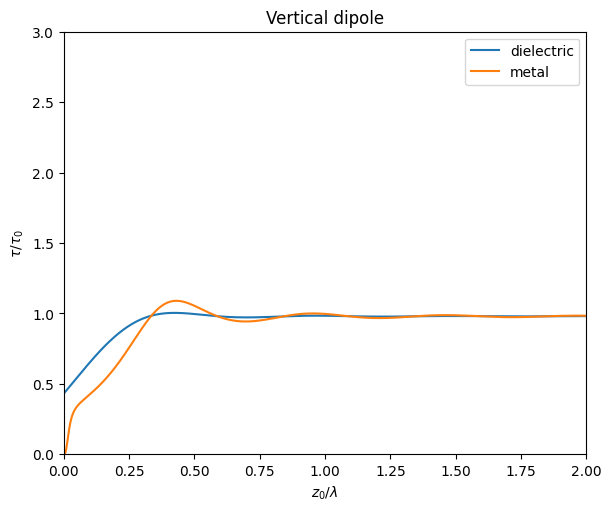

In [51]:
# plot
fig, ax = plt.subplots(figsize=(6,5), layout='constrained') # (width, height) in inches
ax.set_title("Vertical dipole")
# ax.plot(h,gammaRad_rel, label=r"$\tau/\tau_0 (rad)$")
# ax.plot(h,gammaNR_rel, label=r"$\tau/\tau_0 (non rad)$")
ax.plot(h,1/gammaD_rel, label=r"dielectric")
ax.plot(h,1/gammaM_rel, label=r"metal")
# ax.plot(norm_height,1/(gamma_radm+gamma_nonradm), label=r"metal")
ax.set_ylim(0,3)
ax.set_ylabel(r"$\tau/\tau_0$")
ax.set_xlabel(r"$z_0/\lambda$")
l = ax.legend(loc='upper right', fancybox=True)
ax.set_xlim([0, 2])
plt.show()

#

- The dipole orientation that leads to the strongest decay rate perturbation in the interval [1/2,2] is the horizontal dipole orientation, because in this interval the contribution from the non-radiative decay rate is negligible and the radiative dipole emission is mostly perpendicular to the dipole axis.
- The dipole orientation that leads to the strongest decay rate perturbation in the interval [0,1/2] is the vertical dipole orientation, because in this interval the contribution from the non-radiative decay rate is significant and the non-radiative dipole emission is mostly along the dipole axis.